# DeepInsight SqueezeNet Example

This example shows a case of using the output of 
pyDeepInsight.ImageTransformer to train a SqueezeNet model
using PyTorch.

## DeepInsight

In [1]:
from pyDeepInsight import ImageTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [2]:
random_state=1515

Load example TCGA data and split into training and testing sets

In [3]:
expr_file = r"./data/tcga.rnaseq_fpkm_uq.example.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['project'].values
X = expr.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

Normalize data using StandardScaler and create tsne class

In [4]:
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

In [5]:
tsne = TSNE(
    n_components=2,
    random_state=random_state,
    n_jobs=-1)

Initialize image transformer.

In [6]:
it = ImageTransformer(
    feature_extractor=tsne, 
    pixels=32)

Train image transformer on training data and transform training 
and testing sets

In [7]:
X_train_img = it.fit_transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

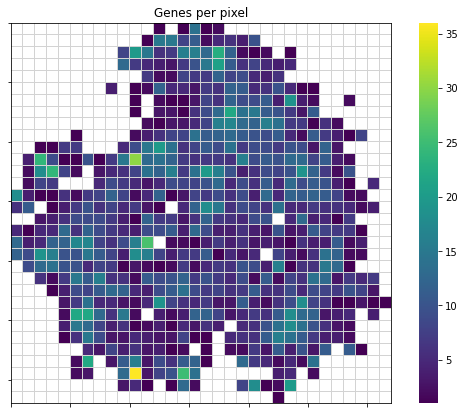

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

The following are showing plots for the image matrices first four samples 
of the training set. 

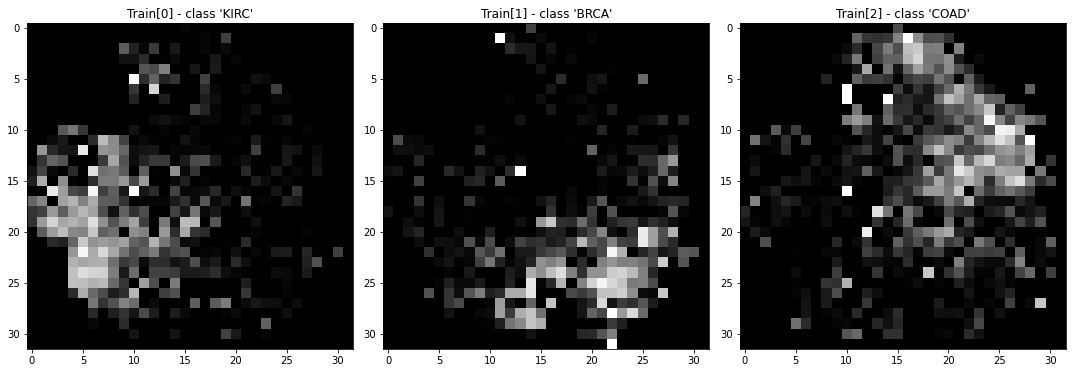

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text("Train[{}] - class '{}'".format(i, y_train[i]))
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

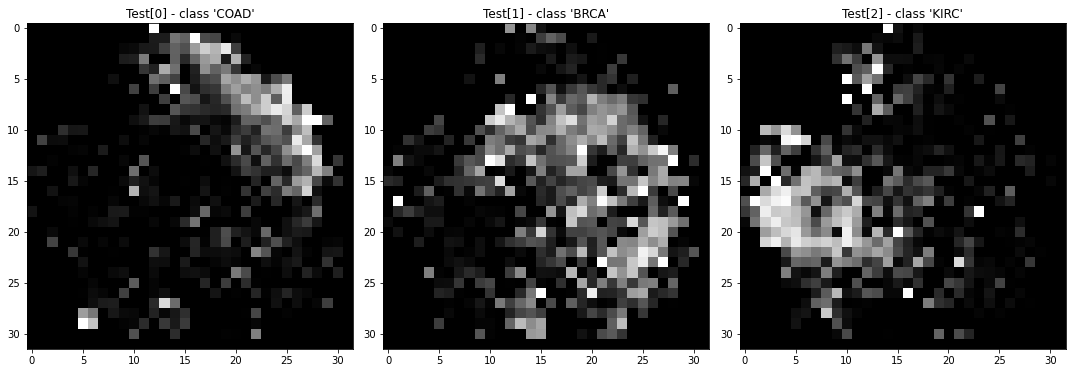

In [10]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text("Test[{}] - class '{}'".format(i, y_test[i]))
plt.tight_layout()

## SqueezeNet

In [11]:
import torch
device = torch.device("cpu")
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import warnings; 
warnings.simplefilter('ignore')

Encode labels as integers.

In [12]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Download [PyTrorch SqueezeNet 1.1][1] and modify output layer as 
to match number of labels as described in [Finetuning Torchvision Model][2].

[1]: https://pytorch.org/hub/pytorch_vision_squeezenet/
[2]: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [13]:
net = torch.hub.load(
    'pytorch/vision:v0.6.0', 'squeezenet1_1', 
    pretrained=False, verbose=False).double()
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), 
                              stride=(1,1)).double()

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not 
required.


In [14]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [15]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img])
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img])
y_test_tensor = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [16]:
batch_size = 1

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

Specify loss function and optimization algorithm

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

Train SqueezeNet for 20 epochs

In [18]:
for epoch in range(20):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss / len(X_train_tensor) * batch_size))

[1] loss: 1.094
[2] loss: 0.917
[3] loss: 0.472
[4] loss: 0.289
[5] loss: 0.207
[6] loss: 0.151
[7] loss: 0.154
[8] loss: 0.102
[9] loss: 0.068
[10] loss: 0.065
[11] loss: 0.059
[12] loss: 0.100
[13] loss: 0.032
[14] loss: 0.043
[15] loss: 0.039
[16] loss: 0.022
[17] loss: 0.017
[18] loss: 0.014
[19] loss: 0.033
[20] loss: 0.051


Calculate accuracy of prediction

In [19]:
train_outputs = net(X_train_tensor)
_, train_predicted = torch.max(train_outputs, 1)

In [20]:
test_outputs = net(X_test_tensor)
_, test_predicted = torch.max(test_outputs, 1)

In [21]:
print("The train accuracy was {:.3f}".format(accuracy_score(train_predicted, y_train_tensor)))
print("The test accuracy was {:.3f}".format(accuracy_score(test_predicted, y_test_tensor)))

The train accuracy was 0.994
The test accuracy was 0.975
